In [1]:
import pints
import pints.toy as toy
import pints.plot

import emupints
import emupints.plot as emuplt
import emupints.utils as emutils
import emupints.metrics as emumet

import numpy as np
import matplotlib.pyplot as plt
import GPy
from GPy import kern as kern

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import string
from itertools import product

## Specifying model

In [2]:
# Load problem from predefined ones
model = emupints.Problems.LotkaVolterraModel
problem = emupints.Problems.load_problem(model)

problem['values'][:5]

array([[2.04683184, 2.02395305],
       [1.95423574, 1.96744505],
       [1.98424208, 2.01555673],
       [1.89406429, 2.07483967],
       [1.87519882, 2.1837747 ]])

In [3]:
# take all the required variables from the problem
n_parameters = problem['n_parameters']
log_likelihood = problem['log_likelihood']
log_prior = problem['log_prior']
log_posterior = problem['log_posterior']
real_parameters = problem['parameters']
pints_problem = problem['problem']
bounds = problem['bounds']
index_to_param_name = problem['param_names']

# Apply CMA-ES

In [4]:
# CMA-es
score = pints.SumOfSquaresError(pints_problem)
x0 = bounds.sample(1)[0]

found_parameters, found_value = pints.optimise(
    score,
    x0,
    None,
    bounds,
    method=pints.CMAES
)

Minimising error measure
using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 8
Iter. Eval. Best      Time m:s
0     8      28.63502   0:00.1
1     16     2.304171   0:00.1
2     24     2.304171   0:00.1
3     32     2.304171   0:00.1
20    168    1.618851   0:00.2
40    328    1.568697   0:00.4
60    488    1.568141   0:00.6
80    648    1.568139   0:00.7
100   808    1.568139   0:00.9
120   968    1.568139   0:01.1
140   1128   1.568139   0:01.3
160   1288   1.568139   0:01.6
180   1448   1.568139   0:01.8
200   1608   1.568139   0:01.9
220   1768   1.568139   0:02.1
240   1928   1.568139   0:02.3
260   2088   1.568139   0:02.4
280   2248   1.568139   0:02.6
300   2408   1.568139   0:02.7
302   2416   1.568139   0:02.7
Halting: No significant change for 200 iterations.


# Use found parameters to sample trianing data

In [5]:
# training size
# use bigger training size for NNs because speed stays the same
train_size = 500
test_size = 1000
sampling_std = 0.05 * found_parameters # take 5% around found parameters std

def normal_sampling(size, mean, std):
    return mean + np.random.randn(*size) * std

# create data for training and testing
# genera example using normal distribution around parametrs
train_X = normal_sampling((train_size, n_parameters), found_parameters, sampling_std)
train_y = np.apply_along_axis(log_likelihood, 1, train_X)

# if provide validation data to keras model also need to normalize it 
test_X = normal_sampling((test_size, n_parameters), found_parameters, sampling_std)
test_y = np.apply_along_axis(log_likelihood, 1, test_X)

## Creating GP and selecting kernel

In [6]:
emu = emupints.GPEmulator(log_likelihood,
                          train_X,
                          train_y,
                          input_scaler=StandardScaler(),
                         )

In [7]:
n_parameters = emu.n_parameters()


kernels = [
    kern.Linear(n_parameters),
    kern.RBF(n_parameters),
    kern.RatQuad(n_parameters),
    kern.MLP(n_parameters),
    kern.Matern52(n_parameters),
    kern.RatQuad(n_parameters) + kern.RBF(n_parameters),
    kern.Matern52(n_parameters) + kern.RBF(n_parameters),
    kern.RatQuad(n_parameters) + kern.RBF(n_parameters),
    kern.MLP(n_parameters) + kern.Matern52(n_parameters) + kern.RatQuad(n_parameters),
]

kernel_names = [
    'Linear',
    'RBF',
    'RatQuad',
    'MLP',
    'Matern',
    'RatQuad + RBF',
    'Matern52 + RBF',
    'RatQuad + RBF',
    'MLP + Matern + RatQuad'
]

# kernels that have been optimized for input data
trained_kernels = []

# possible optimizers: 
# ‘scg’, ‘lbfgs’, ‘tnc’
# can specify max number of iterations using max_iters
optimizer = "lbfgs"
max_iters = 500
emu.set_parameters(optimizer = optimizer)

In [8]:
# when the output data is normalized values of variance should be small
# hence ignore any kernel that has a subkernel 
# (i.e kernel that is a part of sum/product) 
# with variance > 1000
# set avoid_overfitting to False to stop this effect
avoid_overfitting = False
variance_threshold = 1000

# store prediction time for comparison
likelihood_time = %timeit -o log_likelihood(real_parameters)
likelihood_time = likelihood_time.average

3.67 ms ± 567 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [9]:
marginal_likelihoods = []
prediction_times = []

for kernel, kernel_name in zip(kernels, kernel_names):
    emu.set_parameters(kernel = kernel)
    emu.fit(optimize = False, normalizer = True)
    emu.optimize(max_iters = max_iters, messages = False)

    trained_kernel = emu.get_trained_kern()
    trained_kernels.append(trained_kernel)

    # time prediction
    emu_time =  %timeit -o emu(real_parameters)
    prediction_times.append(emu_time.average)

    ml = emu.get_log_marginal_likelihood()
    marginal_likelihoods.append(ml)
    print("{}: {:.2f}".format(kernel_name, ml))

323 µs ± 12.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Linear: -709.45
386 µs ± 20.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
RBF: 2965.73
546 µs ± 103 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
RatQuad: 3030.34
666 µs ± 77.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
MLP: 2856.54


 /Users/maksympetyak/Prog/emupints/env/lib/python3.6/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/maksympetyak/Prog/emupints/env/lib/python3.6/site-packages/GPy/kern/src/stationary.py:551: RuntimeWarning:overflow encountered in multiply
 /Users/maksympetyak/Prog/emupints/env/lib/python3.6/site-packages/GPy/kern/src/stationary.py:551: RuntimeWarning:overflow encountered in square
 /Users/maksympetyak/Prog/emupints/env/lib/python3.6/site-packages/GPy/kern/src/stationary.py:551: RuntimeWarning:invalid value encountered in multiply


662 µs ± 164 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Matern: 1963.29
1.05 ms ± 54.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
RatQuad + RBF: 3029.44
1.11 ms ± 109 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Matern52 + RBF: 2972.46
866 µs ± 63.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
RatQuad + RBF: 3029.44
1.45 ms ± 139 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
MLP + Matern + RatQuad: 1981.77


In [10]:
best_kernel = None
best_score = -1 << 31
best_time = -1 << 31

# find kernel with highest log marginal likelihood
for kernel, score, emu_time in zip(trained_kernels, marginal_likelihoods, prediction_times):
    # ignore any overfitting kernel
    if avoid_overfitting and emutils.has_high_variance(kernel, threshold = variance_threshold):
        continue
    
    # avoid kernels that don't provide 5x speed up
    if 5 * emu_time > likelihood_time:
        continue

    if score > best_score:
        best_kernel = kernel
        best_time = emu_time
        best_score = best_score
        
print('Prediction time: ', best_time)
best_kernel

Prediction time:  0.0006616376003782664


Mat52.,value,constraints,priors
variance,539319.7779484473,+ve,
lengthscale,133.5438222747058,+ve,


In [11]:
emu.set_parameters(kernel = kernels[-3])
emu.fit(optimize = False, normalizer = True)
emu.optimize(max_iters = max_iters, messages = True)    

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    00s06  001   5.307083e+02   2.193933e+04 
    00s17  003  -4.856692e+02   4.762140e+04 

 /Users/maksympetyak/Prog/emupints/env/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1



    03s21  082  -2.972459e+03   1.358802e-02 
    03s72  092  -2.972459e+03   1.358802e-02 
Runtime:     03s72
Optimization status: Errorb'ABNORMAL_TERMINATION_IN_LNSRCH'



In [12]:
emu.get_gp()

GP_regression.,value,constraints,priors
sum.Mat52.variance,343.0567027196702,+ve,
sum.Mat52.lengthscale,3279.5731171458374,+ve,
sum.rbf.variance,2436.220377465099,+ve,
sum.rbf.lengthscale,8.090447153489235,+ve,
Gaussian_noise.variance,5.213652675598139e-13,+ve,


# Likelihood metrics

In [13]:
emu_time = %timeit -r 50 -o emu(real_parameters)
print("Emulator prediction time (micro-seconds): {:5f}".format(emu_time.average * 1000000))

712 µs ± 32.7 µs per loop (mean ± std. dev. of 50 runs, 1000 loops each)
Emulator prediction time (micro-seconds): 712.297360


In [14]:
likelihood_time = %timeit -r 50 -o log_likelihood(real_parameters)
print("Likelihood prediction time (micro-seconds): {:5f}".format(likelihood_time.average * 1000000))

2.83 ms ± 111 µs per loop (mean ± std. dev. of 50 runs, 100 loops each)
Likelihood prediction time (micro-seconds): 2833.210056


In [15]:
pred_y = np.apply_along_axis(emu, 1, test_X)
print("Mean absolute error (mae): {:.5f}".format(emumet.mae(test_y, pred_y)))

Mean absolute error (mae): 1299.55709


In [16]:
print("Mean percentage error (mape): {:.5f}".format(emumet.mape(test_y, pred_y) * 100))

Mean percentage error (mape): 1063.36184


# Comparing MCMC run times

In [17]:
mcmc_method = pints.AdaptiveCovarianceMCMC

# MCMC parameters
num_chains = 3
max_iters = 10000

In [18]:
# Create a posterior log-likelihood (log(likelihood * prior))
emu_log_posterior = pints.LogPosterior(emu, log_prior)

In [19]:
xs = [
    found_parameters,
    found_parameters * 1.01,
    found_parameters * 0.99
]
xs

[array([3.05905737, 2.03510019, 2.93710239, 1.96514815]),
 array([3.08964794, 2.05545119, 2.96647342, 1.98479963]),
 array([3.02846679, 2.01474919, 2.90773137, 1.94549667])]

In [20]:
emu_mcmc = pints.MCMCSampling(emu_log_posterior,
                              num_chains,
                              xs,
                              method = mcmc_method,
                             )
emu_mcmc.set_log_to_screen(False)
print('Running...')
emu_chains = emu_mcmc.run()
print('Done!')

Running...
Done!


In [21]:
real_mcmc = pints.MCMCSampling(log_posterior, 
                               num_chains, 
                               xs, 
                               method = mcmc_method,
                               )
real_mcmc.set_max_iterations(max_iters)
real_mcmc.set_log_to_screen(False)
# Run!
print('Running...')
real_chains = real_mcmc.run()
print('Done!')

Running...
Done!


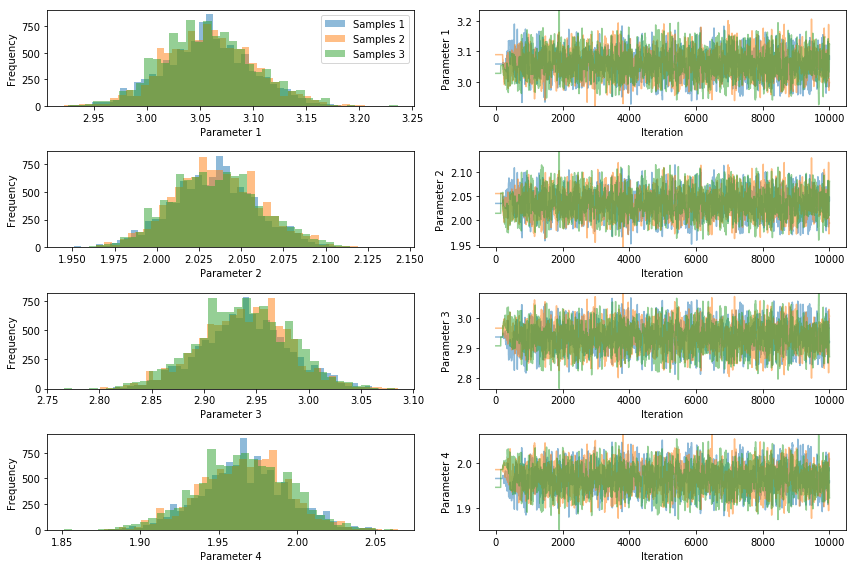

In [22]:
pints.plot.trace(emu_chains)
plt.show()

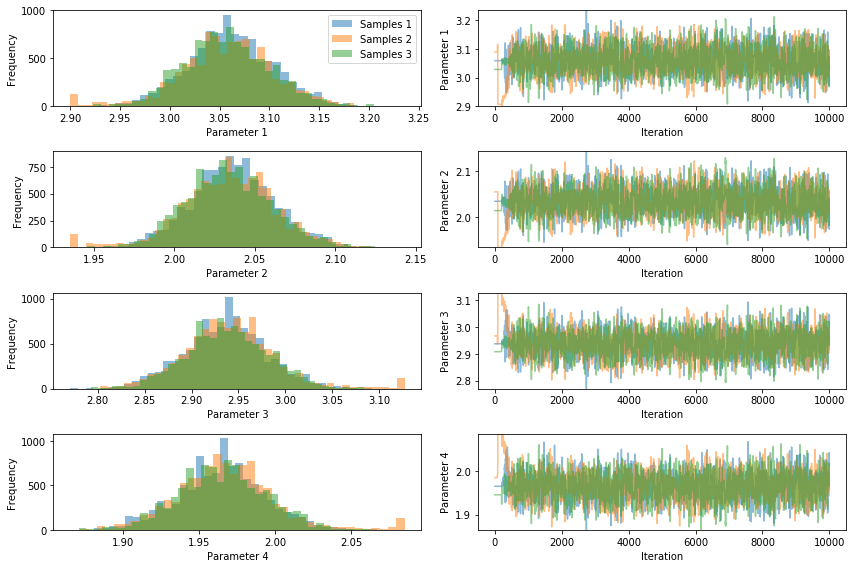

In [23]:
pints.plot.trace(real_chains)
plt.show()

# MCMC metrics

In [24]:
print('Emulator R-hat:')
print(pints.rhat_all_params(emu_chains))

Emulator R-hat:
[1.0002503316684803, 1.0004627050029027, 1.0003253795934905, 1.0002704200327754]


In [25]:
print('Real R-hat:')
print(pints.rhat_all_params(real_chains))

Real R-hat:
[1.0014628227950355, 1.001557832578828, 1.0014326068104729, 1.0012353537564254]


In [26]:
# percentage
chain = real_chains[0]

chain_mape = emumet.chain_mape(chain, emu, log_likelihood)
print("Chain mean absolute percentage error: {:.5f}".format(chain_mape * 100))

Chain mean absolute percentage error: 0.00065


In [36]:
emu_mcmc_time = %timeit -o emu_mcmc.run()
print("Emulator MCMC time: {:.5f}".format(emu_mcmc_time.average))

24.6 s ± 83 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Emulator MCMC time: 24.57172


In [37]:
real_mcmc_time = %timeit -o real_mcmc.run()
print("MCMC time: {:.5f}".format(real_mcmc_time.average))

27.6 s ± 1.61 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
MCMC time: 27.55308


In [29]:
emu_parameters, emu_parameters_std = emumet.estimate_parameters(emu_chains)
print("Emulator estimated parameters: ", emu_parameters)
print("Emulator parametet std: ", emu_parameters_std)

Emulator estimated parameters:  [3.0584607  2.03476825 2.93840167 1.96592724]
Emulator parametet std:  [0.00100618 0.00076316 0.00097607 0.00067091]


In [30]:
real_parameters, real_parameters_std = emumet.estimate_parameters(real_chains)
print("Real estimated parameters: ", real_parameters)
print("Real parameters std: ", real_parameters_std)

Real estimated parameters:  [3.05834268 2.03459566 2.93832413 1.96592406]
Real parameters std:  [0.00251349 0.00170737 0.00300768 0.0017935 ]


# Plotting emulator surfaces around parameters

In [31]:
# use smaller bounds to get an idea of the surface around real parameters
min_bounds = np.min(chain, axis = 0)
max_bounds = np.max(chain, axis = 0)
bounds = pints.RectangularBoundaries(min_bounds, max_bounds)

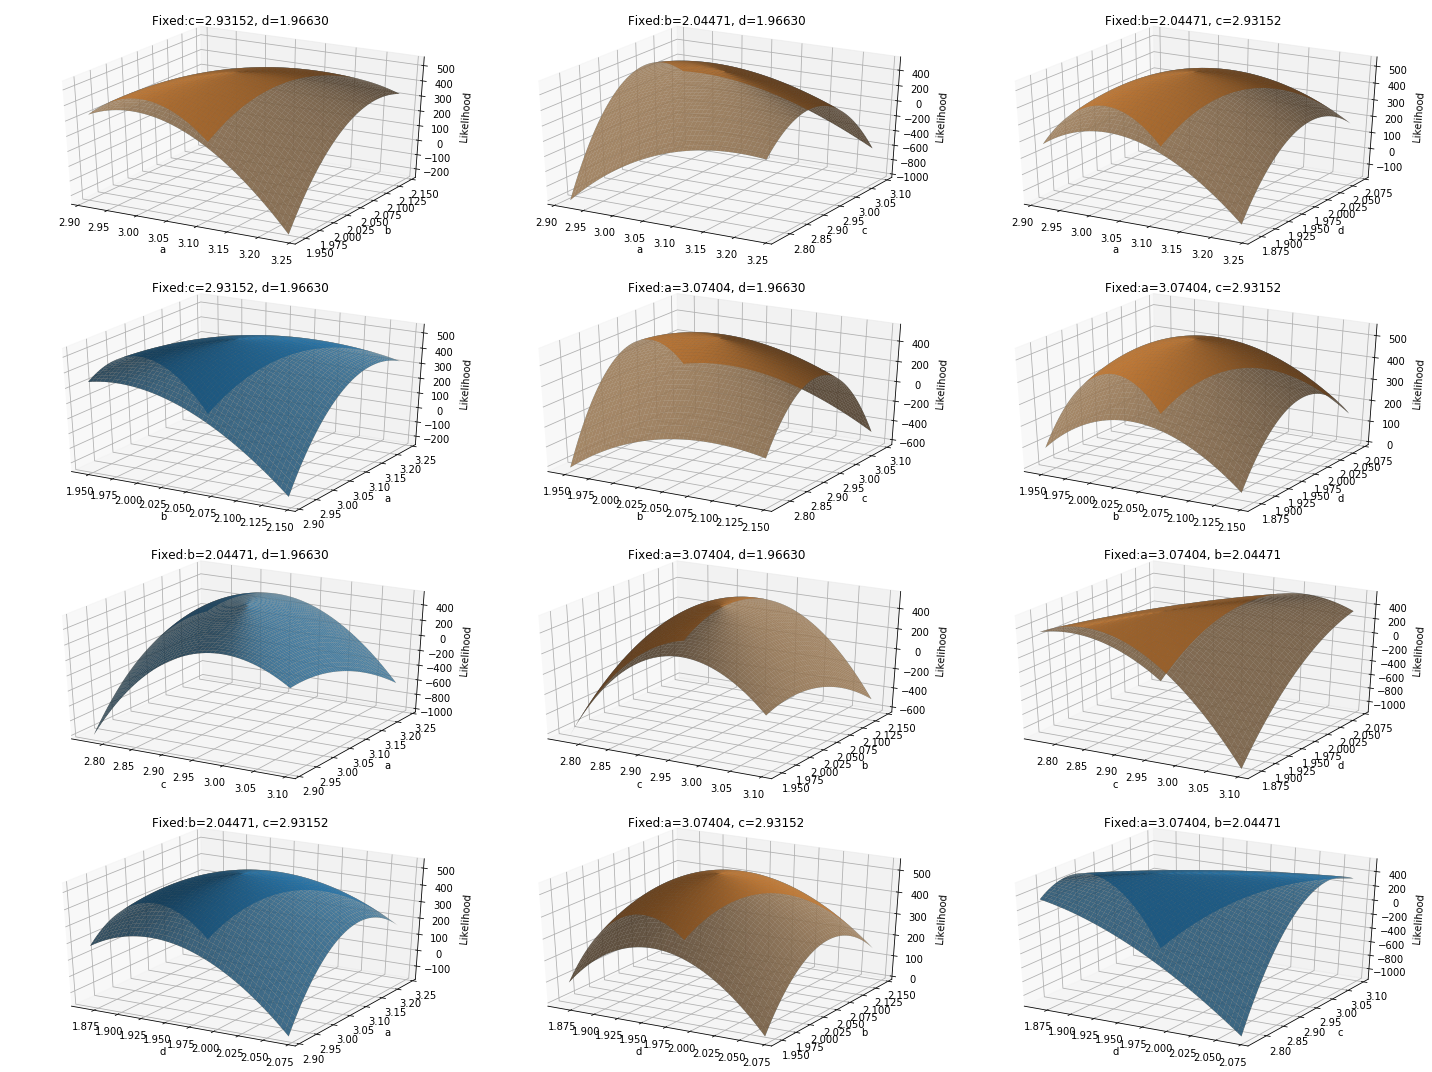

In [32]:
# plot surfaces
if n_parameters >=3:
    fixed_parameters = emutils.fix_parameters(bounds)
    
    fig, ax = emuplt.plot_fixed_param_grid(
        emu,
        fixed_parameters,
        bounds,
        shape = (n_parameters, n_parameters - 1),
        contour = False,
        index_to_param_name=index_to_param_name,
        additional_log_likelihoods = [log_likelihood]
    )

    plt.show(fig)
    
# for row i we have parameter i fixed and some other parameter j, depending on the column, j != i

In [33]:
print(bounds.lower())
print(bounds.upper())

[2.91230175 1.94624663 2.77059476 1.86537792]
[3.23578614 2.14316718 3.09244422 2.06723063]


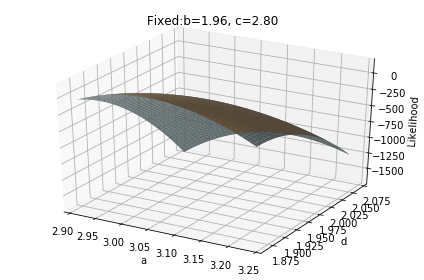

In [34]:
fig, ax = emuplt.plot_surface_fixed_param(
    emu,
    bounds,
    #fixed = [(1, 0.29)],
    index_to_param_name=index_to_param_name,
    contour=False,
    precision=2,
    additional_log_likelihoods=[log_likelihood]
)

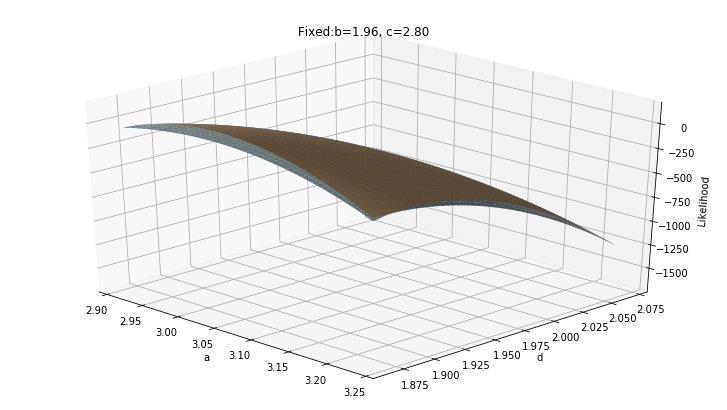

In [35]:
ax.view_init(30, 45 + 90 *3)
fig.set_size_inches(10.5, 6)
fig